
---
# Unit02: Processing passive seismic data.Retrieving earthquake data

This notebook has some practical processing activities of the Course **ProSeisSN**. It deals with data processing using a passive seismic dataset using [ObsPy](https://docs.obspy.org/).

#### Dependencies: Obspy, Numpy, Matplotlib

#### Reset the Jupyter/IPython notebook in order to run it again, press:
***Kernel*** -> ***Restart & Clear Output***

In [1]:
# Import Libraries
import numpy as np

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
"""
Activate the ipympl backend by including
%matplotlib ipympl
magic in the notebook or by
%matplotlib widget
which will have the same effect.

Other magic:
%matplotlib inline
%matplotlib notebook
"""
%matplotlib widget

# Import specialized ObsPy packages + sanity.
try:
    import obspy
    print('obspy version==>', obspy.__version__)
except TypeError:
    print('Stopping RUNTIME. ObsPy not found.')
    exit()

from obspy import read
from obspy import Stream
from obspy import UTCDateTime
from obspy import read, Stream
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import FDSNException

# Local routines. This is just a memo, does not do anything.
from utils import period2freq, freq2period
_ = freq2period(1.)

obspy version==> 1.2.2


---
## Accessing the data

This lecture serves as a basic introduction to using Obspy. Useful links are the official [Obspy Tutorial](https://docs.obspy.org/tutorial/index.html), and the [Seismo-Live Juypter Notebooks for Seismology](https://krischer.github.io/seismo_live_build/tree/index.html).

We work with data form an event occured in Acre in 2024, downloaded using [IRIS Wilber](http://www.iris.edu/wilber3).

|EventID | Time | Lat | Long | Depth(km) | Mww | Location |
| :- | :-: | :- | :- | :-: | :-: | :- |
|11793085|2024-01-20T21:31|-7.2879|-71.464|607|6.6|WESTERN BRAZIL|

We will use a data file in miniSEED format: [wb11793085r.mseed](https://github.com/jandyr/ProSeisSN_Nbk/blob/main/wb11793085_ir.mseed).

Choose stations with epicentral distances $\left[20^{\circ},\,70^{\circ}\right]$; waves travel in the laterally homogeneous Mantle, with P and S arrivals.

Of the 149 stations operational during the event, select station IU HKT, distant $44^{\circ}$ from the event.

|Station|Seismometer| Lat | Long | Depth(m) | Channels |
| :- | :- | :- | :- | :-: | :-: |
|HKT: Hockley1 Texas|Streckeisen STS-6A VBB |29.96|-95.84|93|BH1, BH2, BHZ|

**Phase Arrivals**

|Phase|$\Delta t$| TIme |
| :- | :-: | :- |
|P|+7m 14s|21:38:19|
|PP|+9m 9s |21:40:14|
|S|+13m 4s|21:44:09|
|SS|+16m 38s|21:47:43|

- **Include the instrument response on the data** for removing it later

Use **get_station()** of the FDSN Client to download the station/instrument information as an object. Há dois conjuntos de sensores.

Acre event at HKT with starttime and endtime:
2024-01-20T21:36:19.019539Z 2024-01-20T21:58:18.994539Z


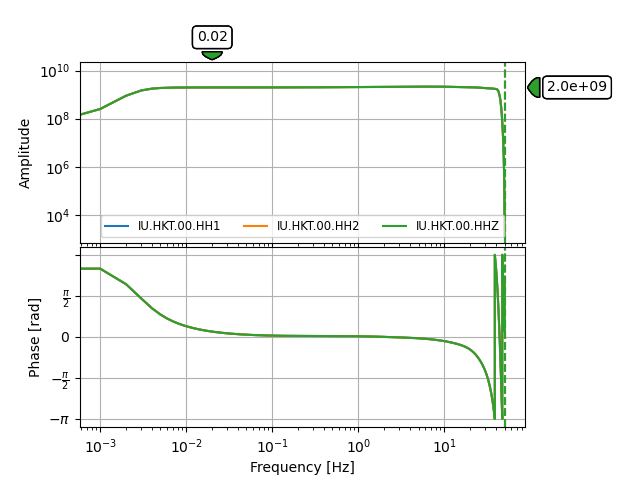

Respnse for the velocity


In [9]:
# Specify event's start and end times
starttime = UTCDateTime("2024-01-20T21:37:19.019539Z") - 60
endtime = UTCDateTime("2024-01-20T21:58:18.994539Z")
print('Acre event at HKT with starttime and endtime:')
print(starttime, endtime)

# Use wildcards to select all three HH* channels
net = "IU"
sta = "HKT"
loc = "00"     #1st set of sensors
chan = "HH*"

# Specify client. Opt:from obspy.clients.earthworm import Client
# Get waveforms with instrument response into a stream
# List of ObsPy clients: clients = ["IRIS", "NCEDC", "USGS", "GEONET", "RESIF", "INGV", "BGR", "ODC", "SCEDC"]
try:
# Download the data with the instrument response
    client = Client("IRIS")
    st0 = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)

# Download the station/instrument information. Plot the velocity.
    sensor = client.get_stations(network=net, station=sta, channel=chan, loc=loc,
                     level="response", 
                     starttime=starttime, endtime=endtime)
    sensor.plot_response(min_freq=0.001, output="VEL");
    print("Respnse for the velocity")
except FDSNException:
    print(f"Chosen client is not working.")
    from obspy.clients.earthworm import Client
    client = Client("ETH")
    st0 = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)

The Bode plots above show the amplitude $A(\omega)$ and the phase $\phi(\omega)$ response for the whole recording chain from observed ground motion to the data, including:

- 1 The analoge response of the seismometer, 

- 2 The response of the analog-to-digitial converter DAC, and

- 3 All stages of the applied digital filters.

The response can be expressed as
$$
R(\omega) = A(\omega) e^{i \phi(\omega)},
$$
where $\omega = 2 \pi f$.

Plot the Z-component/trace stream. The Vertical, z-component, is the last trace.

Instrument response for the 1st set of sensors at HKT:
 Inventory created at 2024-09-17T17:52:41.367300Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?location=00&starttim...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (1):
			IU.HKT (Hockley1 Texas)
		Channels (3):
			IU.HKT.00.HHZ, IU.HKT.00.HH1, IU.HKT.00.HH2
Stream of Acre event at station IU HKT:
 3 Trace(s) in Stream:
IU.HKT.00.HH1 | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:14.538394Z | 100.0 Hz, 41552 samples
IU.HKT.00.HH2 | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:17.648394Z | 100.0 Hz, 41863 samples
IU.HKT.00.HHZ | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:17.688394Z | 100.0 Hz, 41867 samples


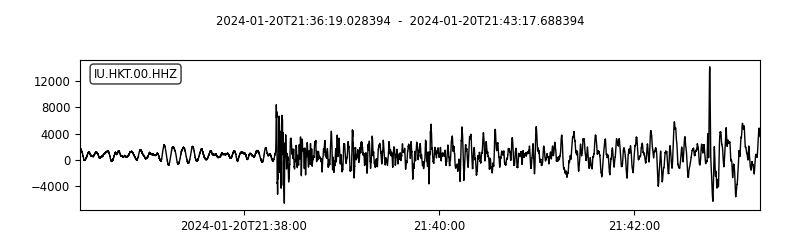

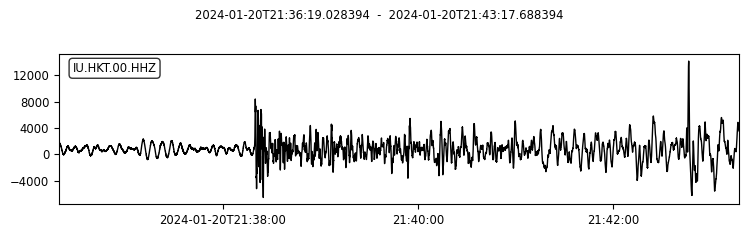

In [7]:
# Provide the instrument response
print(f"Instrument response for the 1st set of sensors at HKT:\n {sensor}")

# Print stream information
print(f"Stream of Acre event at station IU HKT:\n {st0}")

# Plot the z-component, the last in the 3-component/trace stream.
#  3 traces ─>  tr[0,3], note the implicit for loop from 0 to 2 (=3-1!)

#   +─+─> vertical component HZ
st0[-1].plot()

---
### Remove the instrument response

_(i)  If necessary make a *deep* copy of the original stream as the function **remove_response** acts on the data, overwriting the original stream._

_(ii) Express the ground motion in velocity, **output = 'VEL'**, in units of velocity (m/s)._

The process involves multiplication with the inverse of the instrument response, which usually attain small numerical values at both frequency ends. This results in the signal+noise being multiplied by relatively large numbers, making noise contribution large. This can be alleviated by tapering the signal or imposing a *cap* to the inverse of the instrument response.

Note that this is an oversimplification of response removal, which is a more involved process beyond the reach of this course. With the **plot = True** option we can visualize in each step of the response removal process.

The complete options cover the details of:

(a) The deconvolution, water level, frequency domain prefiltering,

(b) The output units (velocity/displacement/acceleration), and

(c) demeaning, tapering.

_Caution:_ The next plots show the pre-filtering and water level options to stabilize the deconvolution of the inverted instrument response spectrum; a numerically unstable operation. 

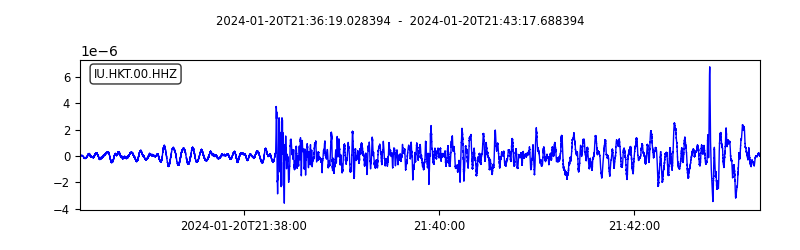

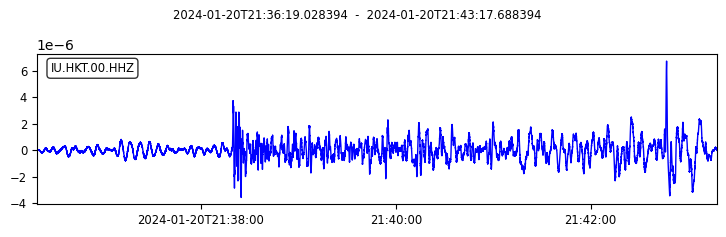

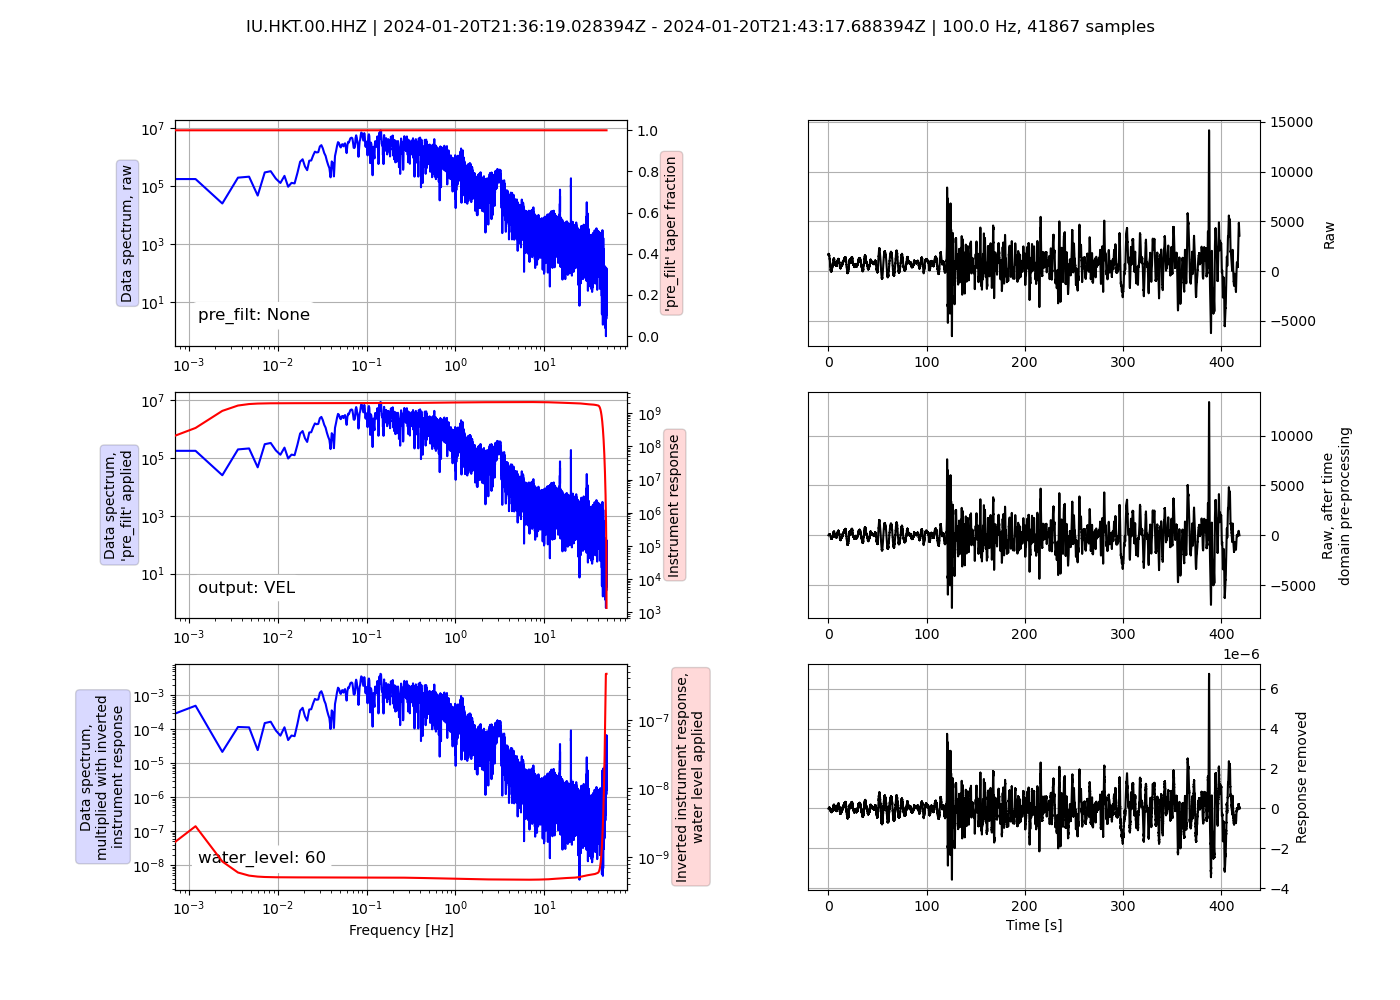

In [11]:
# Deep copy of the original stream
st1 = st0.copy()

# Remove instrument response in Z component/trace. Other options: output = 'DISP', 'ACC'
st1[-1].remove_response(output = 'VEL', plot = True)

# Plot the corrected Z component
st1[-1].plot(color = 'blue')


---
### The frequency content

The [spectrogram](https://docs.obspy.org/tutorial/code_snippets/plotting_spectrograms.html) shows the power in frequency bands (along the y-axis) for every few samples in time (along the x-axis). Warmer colors indicate more power.

The event has a peak of power reaching 5Hz, indicating it is dominated by seismic noise.

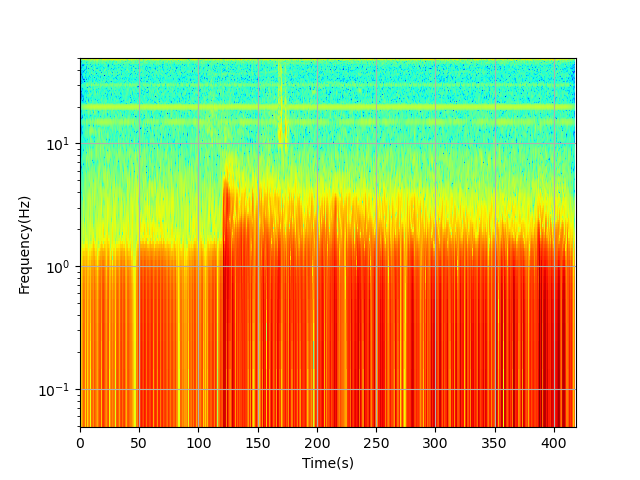

In [5]:
# Construct a figure for BHZ trace
fig, ax = plt.subplots()
_ = st1[-1].spectrogram(log=True, dbscale=True, axes=ax, show=True, cmap = "jet")
plt.xlabel("Time(s)")
plt.ylabel("Frequency(Hz)")
#plt.title("Plot Title")
#plt.legend() # If you have multiple lines in the plot
plt.grid(True) # Add a grid to the plot
plt.show()

---
### Save the corrected data

Save the data with the instrument response removed for further work, in the same directory as this Jupyter notebook.

_Save the data in miniSEED_ specifying file path, name, extension, and data format:

**stream.write('/path/filename.mseed', format='MSEED')**.

In [10]:
# Save the event data (wb=western-brazil, r=nstrument response removed)
filename = 'wb11793085r' + '.mseed'
dummy = input(f'>> Save instrument corrected data '+filename+' (rtn = No): \n') or False
if dummy:
    st1.write(filename, format='MSEED')
    try:
        dummy = read(filename)
        print(f"Instrument-corrected Z-data at station IU HKT:\n {dummy[-1].stats}")
    except:
        print(f".")
        print(f"Failed to write the data if file {filename}")

>> Save instrument corrected data wb11793085r.mseed (rtn = No): 
 i


Instrument-corrected Z-data at station IU HKT:
          network: IU
         station: HKT
        location: 00
         channel: HHZ
       starttime: 2024-01-20T21:36:19.028394Z
         endtime: 2024-01-20T21:43:17.688394Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 41867
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 748, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 1145856})


/srv/conda/envs/notebook/lib/python3.12/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
